In [1]:
# This program computes AIC of gene expression across various distributions
# it then creates line plots that show how these AIC "winners" (those withl lowest AICs)
# in genes segmented by: total read counts 

In [ ]:

from __future__ import print_function

import numpy as np
from scipy.special import gammaln
from scipy.special import psi
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import comb
import math
import sys
import os
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial, Gamma
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

from scipy.stats import expon, nbinom, norm, poisson

import warnings
warnings.filterwarnings("ignore")


# now the DCIS count data is found in an RDA file, which we apparently read using 'pyreadr'
import pyreadr

# thread issues
os.environ['OMP_NUM_THREADS'] = '10'  # Limit to 1 thread
os.environ['MKL_NUM_THREADS'] = '10'  # Limit to 1 thread for MKL (if used)
os.environ['NUMEXPR_NUM_THREADS'] = '10'  # Limit to 1 thread for NumExpr (if used)


# to convert Ensemble to Refseq gene names
gene_convert = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/gene_info/ensemble_to_refseq_gene_name_table.rds')
gene_convert = gene_convert[None]
id_to_name = {gene_id: gene_name for gene_id, gene_name in zip(gene_convert["gene_id"], gene_convert["gene_name"])}


# and a function I use in the document
def variance_mean(row):
    variance = np.var(row, ddof=1) # “Delta Degrees of Freedom”
    mean = np.mean(row)
    std_dev = np.sqrt(variance) # sometimes this is considered dispersion
    
    # I'm a bit confused exactly how I'd compute a dataset-wide dispersion from this data
    # the formula given is Variance = mean + dispersion*mean^2
    # re-arranged, this gives dispersion = (variance - mean)/(mean*mean)
    # I guess we can try it
    dispersion = 0 # in case the mean is zero, or if variance = mean
    if ((mean != 0) & (variance != mean)):
        #dispersion = (variance - mean)/(mean**2)
        dispersion = (mean**2)/(variance - mean) # did I have this backwards?
        inverse_dispersion = dispersion**-1
    
    # and they define "expected fraction zeros" as exp(-mean) - Poisson distribution!
    #prob_frac = math.exp(mean*-1)
    
    # lets do the NB formulation
    prob_frac = 1 # if dispersion is zero, the fraction zero is 100%
    if (dispersion >0):
        prob_frac = ((inverse_dispersion)/(mean + inverse_dispersion))**(inverse_dispersion)
    
    # we will also want to know the fraction of the row that equals zero
    zero_frac = (row == 0).sum()/len(row)
    return pd.Series({'variance': variance, 'mean': mean, "StDev": std_dev, "Dispersion": dispersion, 'zero_fraction': zero_frac, 'prob_frac': prob_frac})

In [3]:
### Parameters ###

# whether or not we're doing outlier removal using trimmed means
trim_means_flag = True
trim_percent = 10 # 1% usually gets rid of most extreme outliers

# genes must be expressed in this % of patients (between 0-1)
express_percent_limit = 0.2 # set to 0 if you want patient stats (all genes with at least 1 read), set to 0.2 if we want AIC stats of genes with >20% expression

# library adjust (using fractional method)
adjust_for_lib = False

# calculate AIC distance
calc_AIC_dist = False # False saves time when running the full program

# a flag if we want to just do "no ZI" or "NB vs ZINB only"
NB_ZINB_only = False # Only comparing NB to ZINB [trim_percent should be low, maybe even zero]

# trim will remove zeroes, so I don't think we should activate trim when doing NB/ZINB comparison
if (NB_ZINB_only == True):
    trim_percent = 0

no_ZI_AICs = False

In [4]:
# non-AIC related functions used in this program    

# computation of gene average, fraction of zeroes, and library size
def dataset_stats_generator(df, draw_zero_distribution = True):
    num_genes = df.shape[0]
    num_samples = df.shape[1]
    # Compute the metrics for each row
    row_sums = df.sum(axis = 0)
    fraction_zero_samples = (df == 0).sum(axis=0) / num_genes
    fraction_zero_genes = (df == 0).sum(axis=1) / num_samples
    row_means = df.mean(axis=1)

    if (draw_zero_distribution):
        plt.hist(fraction_zero_genes, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Fraction of Zeroes (Genes)')
        plt.ylabel('Count')
        plt.title("Fraction of Zeroes per Gene")
        plt.show()

        plt.hist(fraction_zero_samples, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Fraction of Zeroes (Samples)')
        plt.ylabel('Count')
        plt.title("Fraction of Zeroes per Sample")
        plt.show()

        plt.hist(row_means, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Means of Gene Expression')
        plt.ylabel('Count')
        plt.title("Distribution of Means of Genes in Dataset")
        plt.show()
      
    # get the average of these 
    avg_library_size = np.round(np.sum(row_sums) / num_samples, decimals = 0)
    avg_zeroes = np.round(np.sum(fraction_zero_samples) / num_samples, decimals = 3)
    avg_mean_expression = np.round(np.mean(row_means), decimals = 3)
    
    # print("Avg Library Size", "Avg Fraction Zeroes", "Avg Mean Expression")
    return avg_library_size, avg_zeroes, avg_mean_expression

# Simulating some data for illustration
#data = np.random.negative_binomial(10, 0.5, 1000)

def fit_to_nb_plot(data, plotrange = 30):

    # Estimating parameters directly from data
    mean = np.mean(data)
    var = np.var(data)
    p = 1 - (mean / var)
    n = mean * (1 - p) / p

    # Plotting
    plt.hist(data, bins=range(plotrange), align='left', density=True, alpha=0.6, color='g')
    plt.plot(bins[:-1], nbinom.pmf(bins[:-1], n, p), 'ro-', lw=2)
    plt.title("Negative Binomial Fit")
    plt.show()

# adjust for library sizes
def library_adjust(data):
    if (adjust_for_lib):
        library_size = data.sum(axis=0)
        
        cleaned_matrix = np.round((data /library_size)*10000000)
        return cleaned_matrix
    else:
        return data

In [5]:
# functions to compute ZINB

def zinb_loglike(params, counts):
    mu, theta, pi = params
    p = 1 / (1 + mu/theta)
    n = mu * p / (1 - p)
    loglik_pois = nbinom.logpmf(counts, n, p)
    loglik_zero = np.log(pi + (1 - pi) * np.exp(nbinom.logpmf(0, n, p)))
    loglik = np.where(counts == 0, loglik_zero, np.log(1 - pi) + loglik_pois)
    return -np.sum(loglik)

def calculate_aic(loglik, k):
    return 2*k - 2*loglik

def fit_zinb_and_calculate_aic(counts):
    
    initial_params = np.array([np.mean(counts), np.var(counts), 0.5])
    bounds = [(0, None), (0, None), (0, 1)]
    result = minimize(zinb_loglike, initial_params, args=(counts), bounds=bounds)
    mu, theta, pi = result.x
    loglik = -result.fun
    
    k = 3  # Number of parameters
    aic = calculate_aic(loglik, k)
    return mu, theta, pi, aic

In [6]:
# functions to compute ZIP
def zip_loglike(params, counts):
    mu, pi = params
    loglik_pois = poisson.logpmf(counts, mu)
    loglik_zero = np.log(pi + (1 - pi) * np.exp(poisson.logpmf(0, mu)))
    loglik = np.where(counts == 0, loglik_zero, np.log(1 - pi) + loglik_pois)
    return -np.sum(loglik)

def calculate_aic(loglik, k):
    return 2*k - 2*loglik

def fit_zip_and_calculate_aic(counts):
    
    initial_params = np.array([np.mean(counts), 0.5])
    bounds = [(0, None), (0, 1)]
    result = minimize(zip_loglike, initial_params, args=(counts), bounds=bounds)
    mu, pi = result.x
    loglik = -result.fun
    k = 2  # Number of parameters for ZIP model
    aic = calculate_aic(loglik, k)
    return mu, pi, aic

In [7]:
# NEW AIC CALCULATION PROGRAM

# lets turn this into a function
def manual_aic(row):
    nan_flag = 0
    row = np.round(row) # it must be count data

    # trimmed mean to remove outliers
    n = len(row)
    
    if (trim_means_flag):
        elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
        sorted_data = np.sort(row)
        
        if (elements_to_trim > 0):
            row = sorted_data[elements_to_trim:-elements_to_trim]
        else: 
            row = sorted_data

    if (sum(row) <= 0):
        return None, None

    
    # Exponential parameters
    lambda_exp = 1 / np.mean(row)
    log_likelihood_exp = np.sum(expon.logpdf(row, scale=1/lambda_exp))
    aic_exp = 2*1 - 2*log_likelihood_exp  # 1 parameter for exponential

    # NB parameters
    X = sm.add_constant(np.ones(len(row)))
    res = sm.NegativeBinomial(row, X).fit(start_params=[1,1], disp=0)
    
    const = res.params[0]
    alpha = res.params[1]

    mu = np.exp(const)
    p = 1/(1+np.exp(const)*alpha)
    n = np.exp(const)*p/(1-p)

    nb_theta = mu * (1 - p) / p

    aic_nb = res.aic

    if np.isnan(aic_nb):
        aic_diff = None
        nan_flag = 1
    elif np.isnan(aic_exp):
        aic_diff = None
    else:
        aic_diff = aic_nb - aic_exp
        
    return aic_diff, nan_flag


In [8]:
def segmental_aic_find(counts):
    aic_diff_append, nan_fraction = [], []
    
    for i in range(1,5):
        
        # instead of by zero fraction, we split genes by mean expression
        counts.loc[:, 'RowSum'] = counts.sum(axis=1)

        # Sort the DataFrame by the RowSum column
        counts = counts.sort_values(by='RowSum', ascending=False)

        # ditch any row with no reads
        counts = counts[counts['RowSum'] != 0]
        
        # Calculate quartile values
        total_rows = len(counts)
        top_25 = int(total_rows * 0.25)
        middle_50 = int(total_rows * 0.5)
        bottom_25 = int(total_rows * 0.75)
        
        # remove rowsum
        counts = counts.drop(columns=['RowSum'])
        
        top25_percent = counts.iloc[:top_25]
        top50_to25_percent = counts.iloc[top_25:middle_50]
        top75_to50_percent = counts.iloc[middle_50:bottom_25]
        bottom25_percent = counts.iloc[bottom_25:]
        
        # Print the quartiles
        if (i == 1):
            filtered_df = top25_percent
        if (i == 2):
            filtered_df = top50_to25_percent
        if (i == 3): 
            filtered_df = top75_to50_percent
        if (i == 4): 
            filtered_df = bottom25_percent 
            
        num_samples = filtered_df.shape[0]
    
        aic_values = filtered_df.apply(manual_aic, axis=1, result_type='expand')
        aic_values.columns = ['aic_diff', 'nan_flag']
        
        
        mean_aic_diff = np.mean(aic_values['aic_diff'])
        aic_diff_append.append(mean_aic_diff)
        
        nan_sums = np.sum(aic_values['nan_flag'])
        nan_fraction.append(np.round((nan_sums/num_samples)*100))
        
        
    
    return aic_diff_append, nan_fraction
    

In [9]:
# don't forget we want to take the average value

import matplotlib.pyplot as plt

# Create a vector of x-values (input values)
def aic_diff_plot(data, title_add=""):
    x_values = ["Top 25%", "25-50%", "50-75%", "Bottom 25%"]
    # order is: add_vector_nb, add_vector_zinb, add_vector_zip, add_vector_poisson,
    # add_vector_gaussian, add_vector_exp, sample_total
    aic_diff = data[0]
    total_nans = data[1]

    # Create a line plot
    #plt.plot(x_values, aic_diff, marker='o', linestyle='-', label='AIC Difference')
    #plt.plot(x_values, total_nans, marker='o', linestyle='-', label='# NB NaNs')

    fig, ax1 = plt.subplots()
    ax1.plot(x_values, aic_diff, 'b', label='AIC Difference')
    ax1.set_xlabel('Genes Grouped by Most Overall Counts')
    ax1.set_ylabel('AIC NB - AIC Exponential', color='b')
    ax1.tick_params('y', colors='b')

    # Create a second y-axis on the right
    ax2 = ax1.twinx()

    # Create the second plot with a red line (right y-axis)
    ax2.plot(x_values, total_nans, 'r', label='% NB NaNs')
    ax2.set_ylabel('% Genes where NB AICs Failed', color='r')
    ax2.tick_params('y', colors='r')

    # Add a legend that includes both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    title_text = f"Difference in AIC Between NB and Exponential [{title_add}]"
    
    plt.title(title_text)

    # save plot
    plt.savefig('/data/lab_vm/refined/preffect/6_dispersion/6.3_Third_Party_Data.AIC_Distance_Plot_Generator/NB_AIC_Distance_Plot.' +
        str(title_add) + ".ZeroFract_" + str(express_percent_limit) + ".Trim_" + str(trim_percent) + ".pdf",
        dpi=300, bbox_inches='tight') 

    # Show the plot
    plt.show()

In [10]:
# this is a dataset with 528 FFPE breast cancer samples, sequenced from a HiSeq

data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE167977_third_party_ffpe/GSE167977_Raw_Counts.txt',
                  delimiter='\t')

# filter and compute dispersion
# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1) # column 1
tumours_counts = tumours_counts.drop(tumours_counts.columns[-5:], axis=1) # last 5 columns

# adjust for library size (fraction method)
# should come before the gene filter
tumours_counts_lib_adjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_lib_adjust == 0).mean(axis=1)
filtered_df = tumours_counts_lib_adjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print("GSE167977 - Lowest AIC across all genes")

GSE167977_data = segmental_aic_find(tumours_counts)


GSE167977 - Lowest AIC across all genes


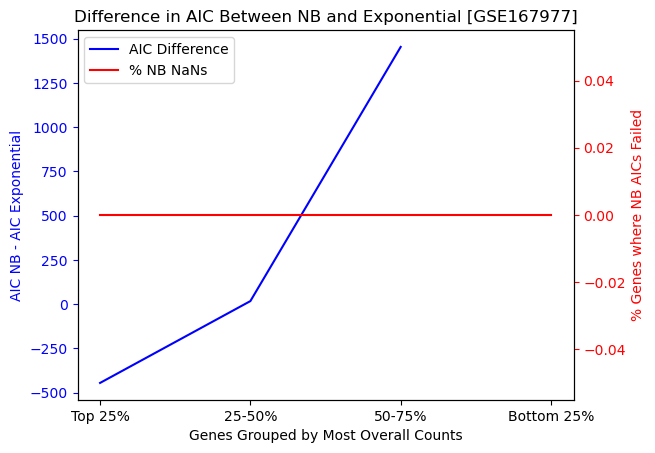

In [11]:
aic_diff_plot(GSE167977_data, "GSE167977")


GSE181466


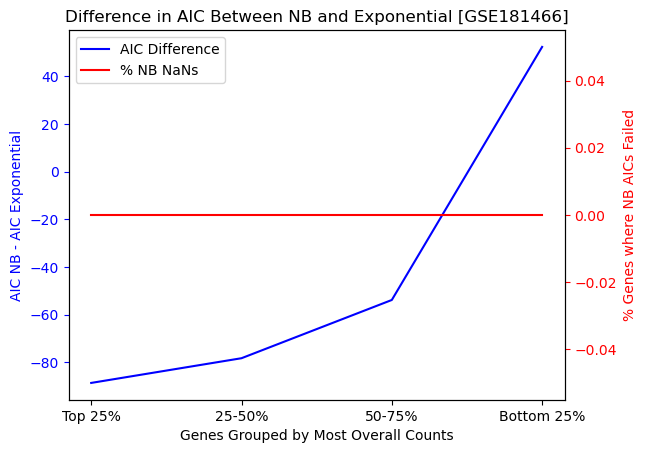

In [12]:
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE181466_third_party_ffpe/GSE181466_rsem_genes_matrix-97.txt',
                  delimiter='\t')

# patient information splitting is unnecessary, this appears to all be both FFPE and from tumours
# there is subtype and age information in the series matrix file, if we're interested

# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
# removing gene column at position 0
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1)
# skip genes that are all zeroes, or just one spurrious read somewhere

# adjust for library size (fraction method)
tumours_counts_libadjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print("GSE181466")
GSE181466_data = segmental_aic_find(tumours_counts)
aic_diff_plot(GSE181466_data, "GSE181466") 


GSE146889 - Tumours


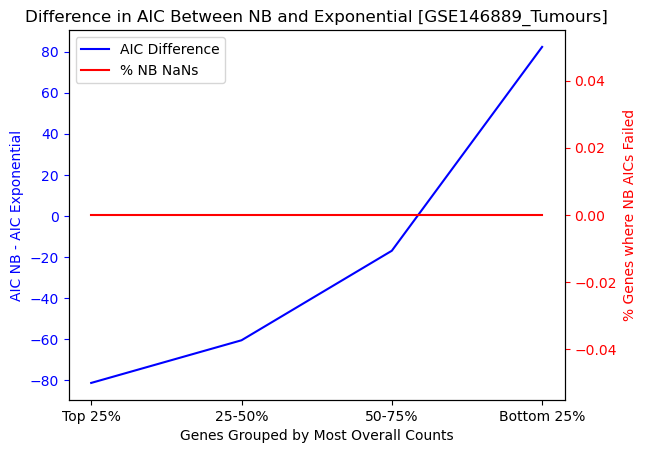

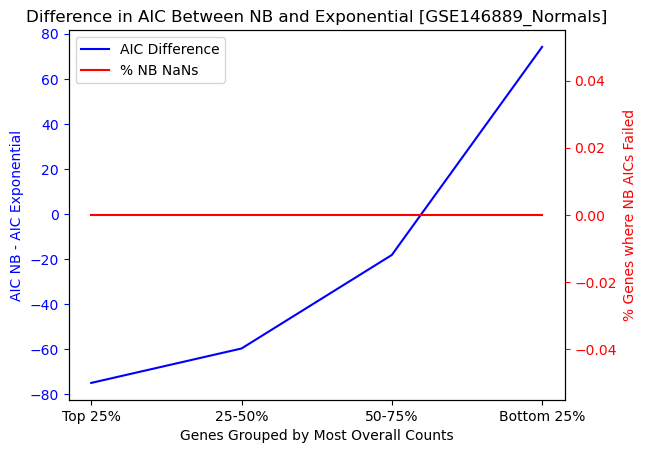

In [13]:
## here, we will repeat our plots but for a different data set
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE146889_third_party_ffpe/GSE146889_GeneCount.rds')
df = all_counts[None] 

# we need to split the tumors and normals by name
count_TUMOR = df.filter(like='tumor')
count_NORMAL = df.filter(like='normal')

count_TUMOR_libadjust = library_adjust(count_TUMOR)
fraction_of_zeroes = (count_TUMOR_libadjust == 0).mean(axis=1)
filtered_tumour = count_TUMOR_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

# adjust for library size (fraction method)
count_NORMAL_libadjust = library_adjust(count_NORMAL)
fraction_of_zeroes = (count_NORMAL_libadjust == 0).mean(axis=1)
filtered_normal = count_NORMAL_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


print("GSE146889 - Tumours")
GSE146889_tum_data = segmental_aic_find(filtered_tumour)
aic_diff_plot(GSE146889_tum_data, "GSE146889_Tumours") 

GSE146889_norm_data = segmental_aic_find(filtered_normal)
aic_diff_plot(GSE146889_norm_data, "GSE146889_Normals") 

GSE209998


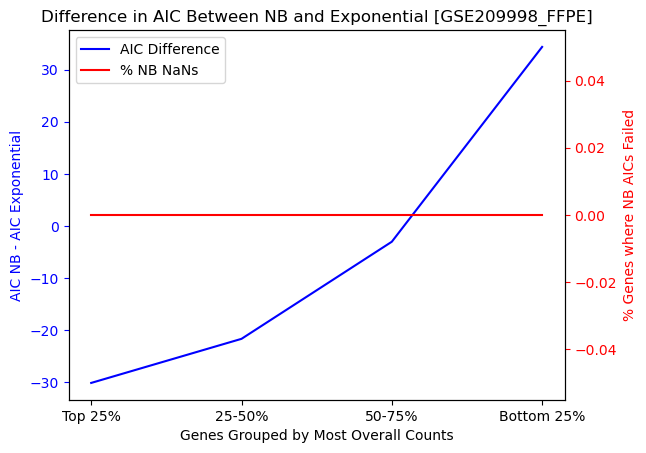

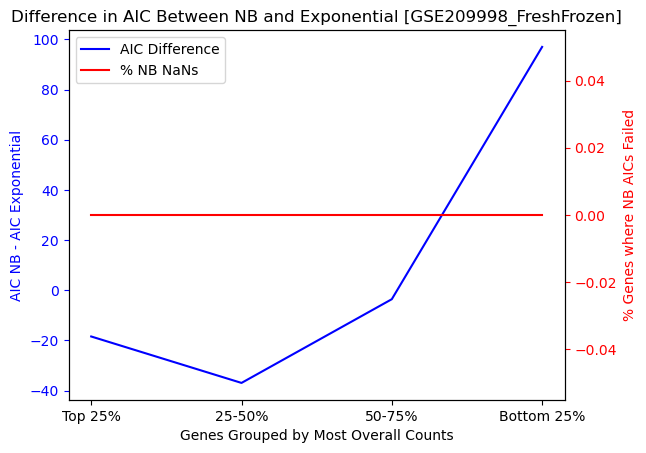

In [14]:
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE209998_third_party_ffpe/GSE209998_GeneCount.rds')
sample_information = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE209998_third_party_ffpe/GSE209998_Sample_Data.rds')

# now we want to isolate just the expression from a particular type of tissue
df_counts = all_counts[None] # load all_counts into a pandas data frame
df_sample = sample_information[None] # load all_counts into a pandas data frame

# here, we need to match if a sample is normal or tumour by !Sample_source_name_ch1 row

# so I need to: 1) match columns between sample_information and all_counts 
# are they in the same order
columns_df1 = df_counts.columns
columns_df2 = df_sample.columns

# Now we find what samples were tumours and what were normal
samples_row = df_sample.loc["!Sample_source_name_ch1"]

split_dfs = {}
for sample_type in samples_row.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and samples_row[col] == sample_type]
    split_dfs[sample_type] = df_counts[matching_columns]

sample_source = df_sample.loc["!Sample_source"]

split_source = {}
for sample_type in sample_source.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and sample_source[col] == sample_type]
    split_source[sample_type] = df_counts[matching_columns]


count_FRESH = split_source["Fresh frozen"]
count_FFPE = split_source["FFPE"]

count_FFPE_libadjust = library_adjust(count_FFPE)
fraction_of_zeroes = (count_FFPE_libadjust == 0).mean(axis=1)
filtered_ffpe = np.round(count_FFPE_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients

count_FRESH_libadjust = library_adjust(count_FRESH)
fraction_of_zeroes = (count_FRESH_libadjust == 0).mean(axis=1)
filtered_fresh = np.round(count_FRESH_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients


print("GSE209998")

GSE209998_ffpe_data = segmental_aic_find(filtered_ffpe)
aic_diff_plot(GSE209998_ffpe_data, "GSE209998_FFPE") 

GSE209998_fresh_data = segmental_aic_find(filtered_fresh)
aic_diff_plot(GSE209998_fresh_data, "GSE209998_FreshFrozen") 



GSE47462


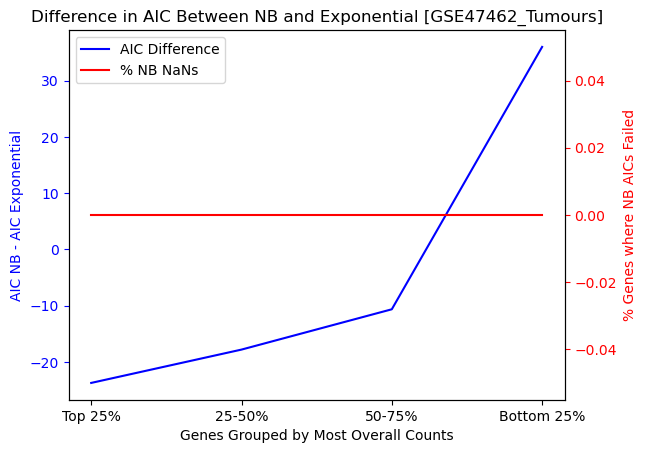

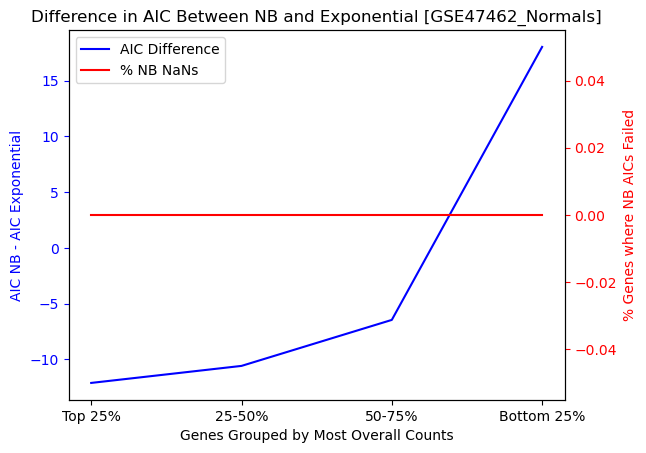

In [15]:
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE47462_third_party_ffpe/GSE47462_Raw_counts_Refseq_genes.txt',
                  delimiter='\t')

# Split the DataFrame into subsets based on column names indicating sample type
normal_data = data.filter(like='_normal')
EN_data = data.filter(like='_EN')
DCIS_data = data.filter(like='_DCIS')
IDC_data = data.filter(like='_IDC')

# since there isn't a ton of data, I also want to group tumors
tumours_data = data.loc[:, ~data.columns.str.contains('_normal')]
tumours_data = tumours_data.iloc[:, 1:]


tumours_data_libadjust = library_adjust(tumours_data)
fraction_of_zeroes = (tumours_data_libadjust == 0).mean(axis=1)
filtered_tumour = tumours_data_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

normal_data_libadjust = library_adjust(normal_data)
fraction_of_zeroes = (normal_data_libadjust == 0).mean(axis=1)
filtered_normal = normal_data_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


print("GSE47462")
GSE47462_tum_data = segmental_aic_find(filtered_tumour)
aic_diff_plot(GSE47462_tum_data, "GSE47462_Tumours") 

GSE47462_norm_data = segmental_aic_find(filtered_normal)
aic_diff_plot(GSE47462_norm_data, "GSE47462_Normals") 


GSE120795


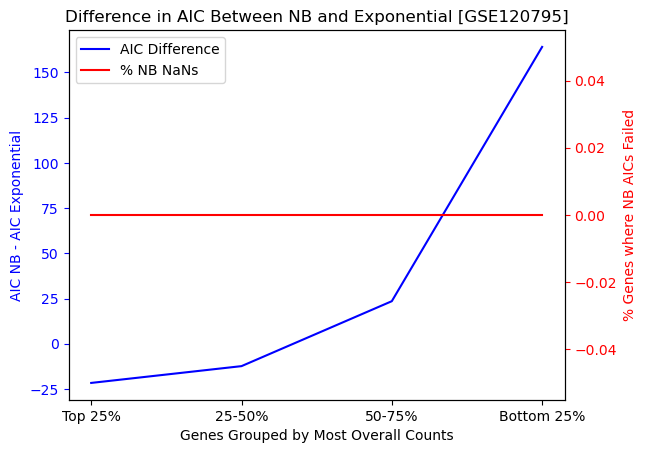

In [16]:
import pandas as pd

# Read the CSV file into a DataFrame
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE120795_third_party_ffpe/GSE120795_total_norms_raw_counts.tsv',
                  delimiter='\t')

# in the series matrix"disease: healthy", 
patient_info = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE120795_third_party_ffpe/GSE120795_cell_info.txt',
                  delimiter='\t')

mask = patient_info.iloc[0] == "healthy"

filtered_data = patient_info.loc[:, mask]
patient_names = filtered_data.columns
column_names_with_extension = [name + ".fastq.gz" for name in patient_names]
column_names_with_extension = column_names_with_extension[1:]

# Assuming 'second_list' is the list where you want to filter based on column names
filtered_data = data[column_names_with_extension]
ffpe_counts = pd.DataFrame(filtered_data)

ffpe_counts_libadjust = library_adjust(ffpe_counts)
fraction_of_zeroes = (ffpe_counts_libadjust == 0).mean(axis=1)
filtered_data = ffpe_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


print("GSE120795")
GSE120795_tum_data = segmental_aic_find(filtered_data)
aic_diff_plot(GSE120795_tum_data, "GSE120795") 


Count Me In


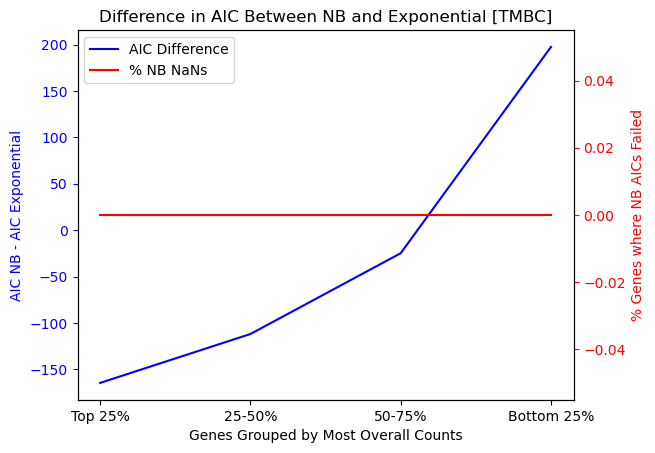

In [17]:
# the GDC Count-Me-In Data
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/CountMeIn_BConly_third_party_ffpe/MBC_CMI_Compiled_Counts.tsv',
                  delimiter=' ')

tumours_counts = pd.DataFrame(data)
tumours_counts = tumours_counts.drop(tumours_counts.columns[:3], axis=1) # columns 1-3 should be ignored

tumours_counts_libadjust = library_adjust(tumours_counts)
fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


print("Count Me In")
TMBC_tum_data = segmental_aic_find(filtered_df)
aic_diff_plot(TMBC_tum_data, "TMBC") 

In [18]:
# Our dataset!
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/expression_counts.Jan2023_1_2_and_2_2.rds')
vst_norm = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/expression_VST_Normalized.Jan2023_1_2_and_2_2.rds')

# this data is loading without issue
ship_data = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/ship1_2_full_tbl.Jan2023.With_Stroma_Assignment.rds')
# I wish that we could've simply used the RDA, but the counts-only RDS works and loads faster so what can you do
# in the future, could try the package 'rpy2' instead, it's an alternative that requires R but that's okay for us

# to do: import Ensemble to Refseq gene name conversion table to fix that
gene_convert = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/gene_info/ensemble_to_refseq_gene_name_table.rds')


# now we want to isolate just the expression from a particular type of tissue
df = all_counts[None] # load all_counts into a pandas data frame

# Eliminate any samples in the blacklist
ship_df = ship_data[None]
#print(ship_df['blacklist'].value_counts()) # they're all false

# since ship_data already has patients filtered out, lets filter out any patient who isn't on the list
# match by 'sample_name'
df_blacklist_filtered = df[ship_df['sample_name']]

# split the patients by tissue
count_DCIS = df_blacklist_filtered.filter(like='_D')
count_STROMA = df_blacklist_filtered.filter(like='_S')
count_NORMAL = df_blacklist_filtered.filter(like='_N')

vst_table = vst_norm[None] # we don't apply this anymore because it blocks any gene with >80% frac_zero
filtered_norm_count = count_NORMAL#[count_NORMAL.index.isin(vst_table.index)]
filtered_tumour_count = count_DCIS#[count_DCIS.index.isin(vst_table.index)]
filtered_stroma_count = count_STROMA#[count_STROMA.index.isin(vst_table.index)]

filtered_norm_count_libadjust = library_adjust(filtered_norm_count)
fraction_of_zeroes = (filtered_norm_count_libadjust == 0).mean(axis=1)
filtered_norm_count = filtered_norm_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_tumour_count_libadjust = library_adjust(filtered_tumour_count)
fraction_of_zeroes = (filtered_tumour_count_libadjust == 0).mean(axis=1)
filtered_tumour_count = filtered_tumour_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_stroma_count_libadjust = library_adjust(filtered_stroma_count)
fraction_of_zeroes = (filtered_stroma_count_libadjust == 0).mean(axis=1)
filtered_stroma_count = filtered_stroma_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


Our Data: Tumours


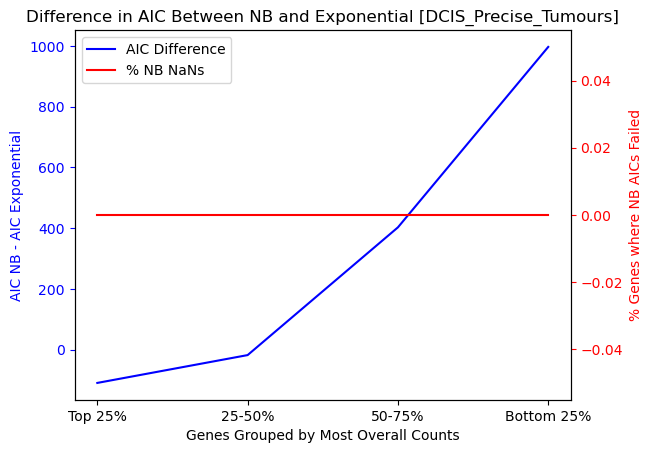

In [19]:
print("Our Data: Tumours")
DCIS_tum_data = segmental_aic_find(count_DCIS)
aic_diff_plot(DCIS_tum_data, "DCIS_Precise_Tumours") 


Our Data: Normal


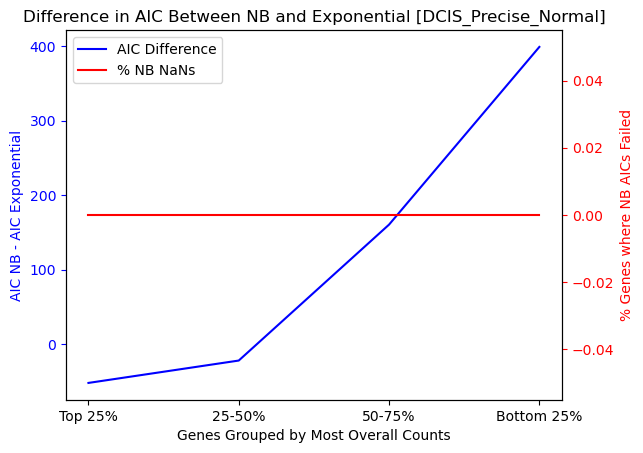

In [20]:
print("Our Data: Normal")
DCIS_norm_data = segmental_aic_find(count_NORMAL)
aic_diff_plot(DCIS_norm_data, "DCIS_Precise_Normal") 

Our Data: Stroma


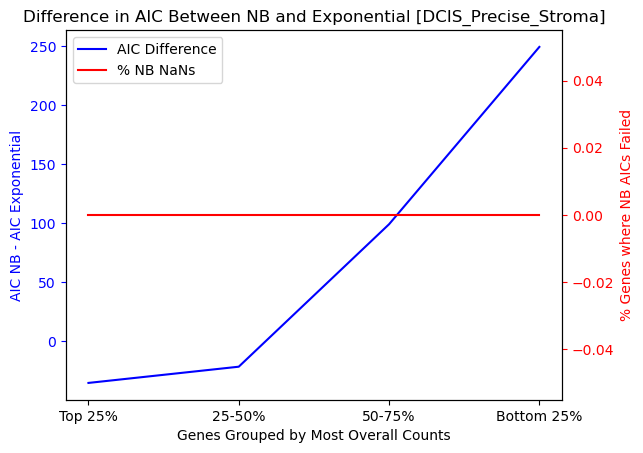

In [21]:
print("Our Data: Stroma")
DCIS_stroma_data = segmental_aic_find(count_STROMA)
aic_diff_plot(DCIS_stroma_data, "DCIS_Precise_Stroma") 

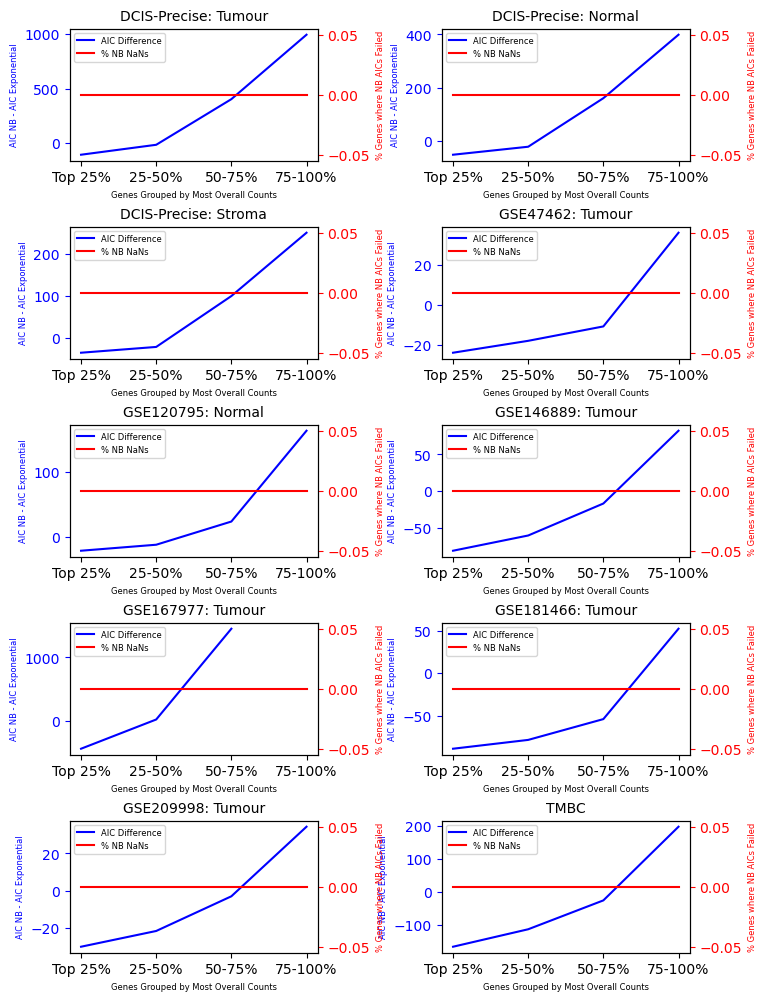

In [22]:
import matplotlib.pyplot as plt

# Create a 5x2 grid of subplots
fig, axs1 = plt.subplots(nrows=5, ncols=2, figsize=(8, 12))  # Adjust figsize as needed
axs2 = [[None for _ in range(2)] for _ in range(5)]

x_values = ["Top 25%", "25-50%", "50-75%", "75-100%"]


for i in range(5):
    for j in range(2):
        if (i == 0) & (j == 0):
            data = DCIS_tum_data
            title_text = "DCIS-Precise: Tumour"
        elif (i == 0) & (j == 1):
            data = DCIS_norm_data
            title_text = "DCIS-Precise: Normal"
        elif (i == 1) & (j == 0):
            data = DCIS_stroma_data
            title_text = "DCIS-Precise: Stroma"
        elif (i == 1) & (j == 1):
            data = GSE47462_tum_data
            title_text = "GSE47462: Tumour"
        elif (i == 2) & (j == 0):
            data = GSE120795_tum_data
            title_text = "GSE120795: Normal"
        elif (i == 2) & (j == 1):
            data = GSE146889_tum_data
            title_text = "GSE146889: Tumour"
        elif (i == 3) & (j == 0):
            data = GSE167977_data
            title_text = "GSE167977: Tumour"
        elif (i == 3) & (j == 1):
            data = GSE181466_data
            title_text = "GSE181466: Tumour"
        elif (i == 4) & (j == 0):
            data = GSE209998_ffpe_data
            title_text = "GSE209998: Tumour"
        elif (i == 4) & (j == 1):
            data = TMBC_tum_data
            title_text = "TMBC"

        # order is: add_vector_nb, add_vector_zinb, add_vector_zip, add_vector_poisson,
        # add_vector_gaussian, add_vector_exp, sample_total
        aic_diff = data[0]
        total_nans = data[1]

        axs1[i, j].plot(x_values, aic_diff, 'b', label='AIC Difference')
        axs1[i, j].set_xlabel('Genes Grouped by Most Overall Counts', fontsize=6)
        axs1[i, j].set_ylabel('AIC NB - AIC Exponential', color='b', fontsize=6)
        axs1[i, j].tick_params('y', colors='b')

        # Create the second plot with a red line (right y-axis)
        axs2[i][j] = axs1[i, j].twinx()
        axs2[i][j].plot(x_values, total_nans, 'r', label='% NB NaNs')
        axs2[i][j].set_ylabel('% Genes where NB AICs Failed', color='r', fontsize=6)
        axs2[i][j].tick_params('y', colors='r')

        # Add a legend that includes both lines
        lines, labels = axs1[i, j].get_legend_handles_labels()
        lines2, labels2 = axs2[i][j].get_legend_handles_labels()
        axs2[i][j].legend(lines + lines2, labels + labels2, loc='upper left', fontsize=6)
        
        plt.title(title_text, fontsize=10)

# Show the plot
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.savefig('/data/lab_vm/refined/preffect/6_dispersion/6.2_Third_Party_Data.Best_AIC_vs_Expression_Level_Plot_Generator/NB_AIC_Distance_Plot.All.' +
    ".ZeroFract_" + str(express_percent_limit) + ".Trim_" + str(trim_percent) + ".pdf",
        dpi=300, bbox_inches='tight')

plt.show()